### HIV Sim Notebook - Dieter Brehm
An implementation of an HIV model

In [3]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [4]:
def make_system(gamma, mu, beta, alpha, sigma, delta, pi, tau, rho, dt):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(R=200, L=0, E=0, V=100)

    t0 = 0
    t_end = 120 * 1/dt

    return System(init=init, t0=t0, t_end=t_end,
                  gamma=gamma, mu=mu, beta=beta, 
                  alpha=alpha, sigma=sigma, delta=delta,
                  pi=pi, tau=tau, rho=rho, dt = dt)

In [5]:
def update_func(state, t, system):
    """Update the HIV model.
    
    state: State (R, L, E, V)
    t: time
    system: System object
    
    returns: State (RLEV)
    """
    
    unpack(system)
    
    r, l, e, v = state
    
    r_flow_in = gamma * tau
    r_flow_death = mu * r
    r_flow_out = beta * r * v
    
    l_flow_in = rho * r_flow_out
    l_flow_death = mu * l
    l_flow_e = alpha * l
    
    e_flow_in = ((1 - rho) * r_flow_out + l_flow_e)
    e_flow_death = delta * e
    
    v_creation_in = pi * e
    v_flow_death = sigma * v
    
    r += (r_flow_in - r_flow_death - r_flow_out) * dt
    l += (l_flow_in - l_flow_death - l_flow_e) * dt
    e += (e_flow_in - e_flow_death) * dt
    v += (v_creation_in - v_flow_death) * dt
    
    return State(R=r, L=l, E=e, V=v)

In [6]:
def plot_results(a, b, c, d):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(a, '--', label='r')
    plot(b, '-', label='l')
    plot(c, '-', label='e')
    plot(d, '-', label='v')
    decorate()
    decorate(xlabel='Time (days)',
             ylabel='Population')

In [7]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

In [43]:
# gamma, mu, beta, alpha, sigma, delta, pi, tau, rho

def plot_simulation_paper_consts():
    Gamma = 1.36
    Mu = 1.36 * (10 ** (-3))
    Beta = 0.00027
    Alpha = 3.6 * (10 ** (-2))
    Sigma = 2
    Delta = 0.33
    Pi = 100
    Tau = 0.2
    Rho = 0.1
    dt = 0.2
    system = make_system(Gamma, Mu, Beta, Alpha, Sigma, Delta, Pi, Tau, Rho, dt)
    results = run_simulation(system, update_func)
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(211)
    ax1.plot(results.R, 'r')
    ax1.set_ylabel('R (r)')
    ax1.set_xlabel('steps')
    
    ax2 = ax1.twinx()
    ax2.set_yscale('linear')
    ax2.set_title('Cells types versus Time step')
    ax2.plot(results.L, 'g', label="L")
    ax2.plot(results.E, 'b', label="E")
    ax2.plot(np.nan, '-r', label = 'R')
    ax2.set_ylabel('L (g), E (b)')
    ax2.set_xlim([0, 150])
    ax2.legend()
    
    fig2 = plt.figure()
    ax1 = fig2.add_subplot(212)
    ax1.plot(results.V, 'r', label="V")
    ax1.set_ylabel('V (r)')
    ax1.set_xlabel('steps')
    ax1.set_xlim([0, 150])
    ax1.set_title('Virions versus Time Step')
    legend(loc="upper right")

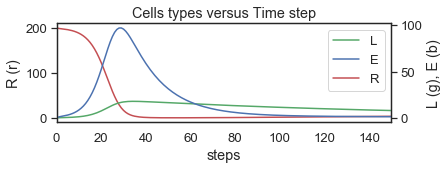

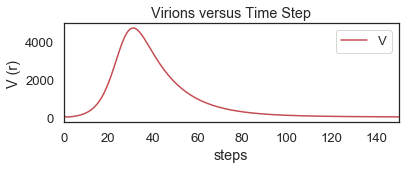

In [44]:
plot_simulation_paper_consts()